In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

In [3]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

In [4]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_AdjD,T2_AdjT,T2_Luck,T2_Strength of Schedule_AdjEM,T2_Strength of Schedule_OppO,T2_Strength of Schedule_OppD,T2_NCSOS_AdjEM,T1_seed,T2_seed,SeedDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,108.7,68.4,0.037,-12.96,94.4,107.4,-8.09,16,16,0
1,2003,134,1411,84,1421,92,0,1,29,67,...,113.5,68.0,0.119,-6.45,98.3,104.7,11.61,16,16,0
2,2003,136,1436,51,1112,80,0,0,20,64,...,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,16,1,15
3,2003,136,1112,80,1436,51,0,0,31,66,...,99.5,64.4,0.019,-5.14,99.3,104.4,-2.29,1,16,-15
4,2003,136,1113,84,1272,71,0,0,31,59,...,94.1,68.3,0.005,4.83,103.4,98.6,3.33,10,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,152,1403,61,1277,51,0,0,22,51,...,90.2,66.9,0.001,13.67,110.6,96.9,3.24,3,2,1
2226,2019,152,1120,62,1438,63,0,0,21,55,...,89.2,59.4,0.050,11.18,109.2,98.1,-3.24,5,1,4
2227,2019,152,1438,63,1120,62,0,0,25,51,...,95.9,67.9,0.008,12.23,110.7,98.5,2.63,1,5,-4
2228,2019,154,1438,85,1403,77,0,1,27,59,...,84.1,66.6,0.004,11.18,109.8,98.7,-5.39,1,3,-2


In [142]:
tourney_data.columns[-40:]

Index(['T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_PFmean',
       'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 'T2_opponent_FGM3mean',
       'T2_opponent_FGA3mean', 'T2_opponent_ORmean', 'T2_opponent_Astmean',
       'T2_opponent_TOmean', 'T2_opponent_Stlmean', 'T2_opponent_Blkmean',
       'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
       'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
       'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
       'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
       'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
       'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
       'SeedDiff'],
      dtype='object')

# Model Building

In [5]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [6]:
features = [
       'location', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
       'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
       'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
       'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
       'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
       'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
       'SeedDiff'
]

features2 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
   'SeedDiff'
]


df = tourney_data.dropna(how='any')

X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)

# split training and testing:
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=random_state)

In [144]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

## Random Forest
Just to get warmed up again.

In [145]:
random_state = 1
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

%time model.fit(X_train, y_train)

print_score(model)

Wall time: 247 ms
train log loss:  0.13342979545364902
val log loss:  0.6074676308188095
training r^2:  0.9071684183947226
validation r^2:  0.31431529322548035


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


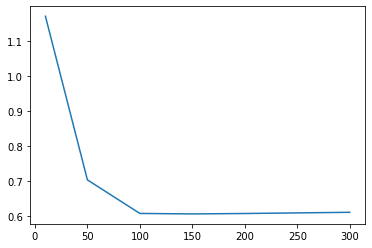

In [146]:
n_trees = [10, 50, 100, 150, 200, 300]
val_log_loss = []
for n in n_trees:
    model = RandomForestRegressor(
        n_estimators=n, n_jobs=-1, oob_score=True, random_state=random_state
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(n_trees, val_log_loss)

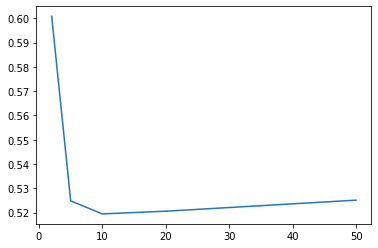

In [148]:
params = dict(
    n_jobs=-1,
    oob_score=True, 
    n_estimators=100,
)

min_samples_leaf = [2, 5, 10, 20, 50]
val_log_loss = []
for msl in min_samples_leaf:
    model = RandomForestRegressor(  
        min_samples_leaf=msl,
        **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(min_samples_leaf, val_log_loss)

In [149]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['min_samples_leaf'] = min_samples_leaf[idx]

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 100, 'min_samples_leaf': 10}


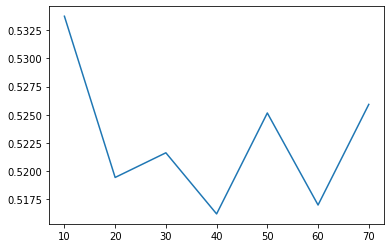

In [150]:
max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70]
print(params)

val_log_loss = []
for m in max_leaf_nodes:
    model = RandomForestRegressor(
     max_leaf_nodes=m, **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(max_leaf_nodes, val_log_loss)

In [151]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['max_leaf_nodes'] = max_leaf_nodes[idx]
print("Max leaf nodes: ", max_leaf_nodes[idx])

Max leaf nodes:  40


In [152]:
print(params)
model = RandomForestRegressor(
     **params
    )
model.fit(X_train, y_train)
print_score(model)

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 100, 'min_samples_leaf': 10, 'max_leaf_nodes': 40}
train log loss:  0.32761661338612597
val log loss:  0.5213464215285195
training r^2:  0.6123397815297564
validation r^2:  0.29836295356540043
oob score:  0.3606834326939863


## CV Pipe

In [153]:
from sklearn.model_selection import LeaveOneGroupOut
def cv_score(m, X_test_, y_test_, print_=True):
    res = log_loss(y_test_, m.predict(X_test_))
    if print_: print(f"Val log loss: {res}")
    return res

def leave_one_out_CV(estimater, params, folds, df, features):
    X = df[features].copy()
    y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
    groups = df['Season'].values - 2003

    # split training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


    cv_res = {}
    group_kfold = LeaveOneGroupOut()
    groups_ = groups[X_train.index]

    for i in range(folds):
        cv_res[i] = []
        for train_index, test_index in group_kfold.split(X_train.values, y_train, groups_):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train[train_index], y_train[test_index]

            if hasattr(estimater, "random_state"):
                params['random_state'] = i

            m = estimater(**params)
            m.fit(X_train_, y_train_)
            cv_res[i].append(cv_score(m, X_test_, y_test_, print_=False))
        print(f"Fold {i} Log Loss: {np.mean(cv_res[i])}")

    cv_results = [np.mean(vals) for i, vals in cv_res.items()]
    print("CV Fold Results", cv_results)
    print("Mean CV Log Loss: ", np.mean(cv_results))

In [154]:
df = tourney_data.dropna(how='any').reset_index(drop=True)

leave_one_out_CV(estimater=RandomForestRegressor, params=params, 
                 folds=3, df=df, features=features)

Fold 0 Log Loss: 0.5014495996041992
Fold 1 Log Loss: 0.49903129409527336
Fold 2 Log Loss: 0.49717686655088117
CV Fold Results [0.5014495996041992, 0.49903129409527336, 0.49717686655088117]
Mean CV Log Loss:  0.4992192534167846


In [21]:
from sklearn.model_selection import GridSearchCV

def custom_scoring(estimator, X, y):
    return log_loss(y, estimator.predict(X))

# use grid search CV to hyper parameter tune properly:
df = tourney_data.dropna(how='any').reset_index().copy()
X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
groups = df['Season'].values - 2003

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


cv_res = {}
logo = LeaveOneGroupOut()
groups_ = groups[X_train.index]

param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200, 300],
    'min_samples_leaf' : [2, 5, 10, 20, 50],
    'max_leaf_nodes' : [10, 20, 30, 40, 50, 60, 70]
}


gs_cv = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring=None,
    n_jobs=-1,
    cv=logo.split(X_train, y_train, groups_),
    verbose=True
)

# gs_cv.fit(X_train, y_train)

In [22]:
best_model = gs_cv.best_estimator_

print(f"Best params: {gs_cv.best_params_}")
print_score(best_model)

Best params: {'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'n_estimators': 300}
train log loss:  0.4067260131631536
val log loss:  0.50595963487314
training r^2:  0.4833226046018928
validation r^2:  0.31938667607190174


# Linear Models

In [155]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def custom_scoring(estimator, X, y):
    return 1/log_loss(y, estimator.predict(X))

ridge = linear_model.Ridge()

# use grid search CV to hyper parameter tune properly:
df = tourney_data.dropna(how='any').reset_index().copy()
X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
groups = df['Season'].values - 2003

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

groups = groups[X_train.index]

logo = LeaveOneGroupOut()

cv_score = cross_val_score(
        estimator=ridge,
        X=X_train,
        y=y_train,
        groups=groups,
        scoring = custom_scoring,
        cv = logo.split(X_train, y_train, groups),
        n_jobs=-1,
        verbose=0,
    )

In [156]:
# bulk trial:
estimators = [
    linear_model.BayesianRidge(),
    linear_model.ARDRegression(),
    linear_model.ElasticNetCV(),
    linear_model.ElasticNet(),
    linear_model.Lasso(),
    linear_model.LogisticRegression(),
    linear_model.SGDRegressor()
]

scores = {}

for est in estimators:
    scores[est.__class__.__name__] = np.mean(1/cross_val_score(
        estimator=est,
        X=X_train,
        y=y_train,
        groups=groups,
        scoring = custom_scoring,
        cv = logo.split(X_train, y_train, groups),
        n_jobs=-1,
        verbose=0,
    ))

In [157]:
scores

{'BayesianRidge': 0.5118571969592605,
 'ARDRegression': 0.4990101240736376,
 'ElasticNetCV': 0.5252254478360523,
 'ElasticNet': 0.6239820638388103,
 'Lasso': 0.6288067550570536,
 'LogisticRegression': 8.370226391994187,
 'SGDRegressor': 17.31856545483113}

# Model Building Pipeline

In [223]:
features3 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 
   'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 
    'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 
   'SeedDiff'
]

features4 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_AdjEM',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
   'SeedDiff'
]

In [238]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import linear_model

def reg_cv_train(features, estimator, mode='reg', plot=False, verbose=False):
    # get full dataset:
    df = tourney_data.dropna(how='any').reset_index().copy()

    # split X and y:
    X = df[features]
    y = np.where(df['PointDiff'] > 0, 1, 0)

    # use leave-one-group-out:
    logo = LeaveOneGroupOut()
    groups = df['Season']

    cvs = []

    for i , (train_ix, val_ix) in enumerate(logo.split(X, y, groups)):
        # split data:
        X_train = X.iloc[train_ix]
        y_train = y[train_ix]
        X_val = X.iloc[val_ix]
        y_val = y[val_ix]


        # fit pipeline:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.85)),
            ('estimator', estimator)
        ])

        pipe.fit(X_train, y_train)

        # predict values:
        if mode == "reg":
            pred = pipe.predict(X_val)
            pred = np.clip(pred, 0, 1) # because regression
        else:
            pred = pipe.predict_proba(X_val)[:, 1]
        # plot:
        if plot:
            plt.figure(figsize=(15,6))
            plt.subplot(1,2,1)
            plt.scatter(pred, df.loc[val_ix, 'PointDiff'], s=5)
            plt.subplot(1,2,2)
            sns.distplot(pred)
            plt.show()

        # loss:
        loss = log_loss(y_val, pred)
        cvs.append(loss)

        if verbose: print(f"{i+min(groups)} Loss : {loss}")
    
    plt.figure()
    plt.plot(range(min(groups), min(groups) + len(set(groups))), cvs)
    plt.xlabel("Year")
    plt.ylabel("Log Loss")

    print(f"Local CV Loss : {np.mean(cvs):.3f}")
    return np.mean(cvs)

Local CV Loss : 0.530


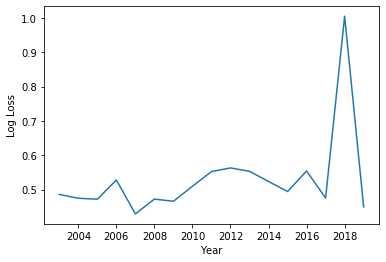

In [239]:
estimator = linear_model.LinearRegression()

plot=False
verbose=True

cvs = reg_cv_train(features=features4, estimator=estimator, mode='reg', 
             plot=False, verbose=False)

Local CV Loss : 0.526
Local CV Loss : 0.527
Local CV Loss : 0.526
Local CV Loss : 0.610
Local CV Loss : 0.693
Local CV Loss : 0.494
Local CV Loss : 0.546


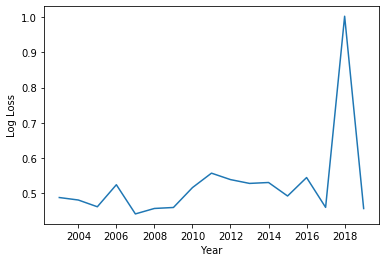

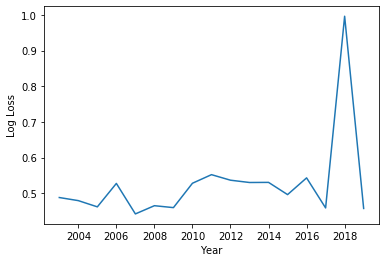

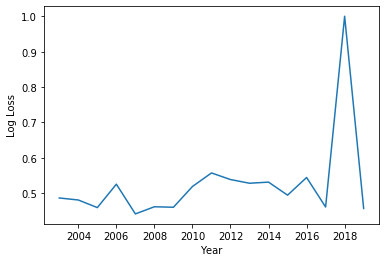

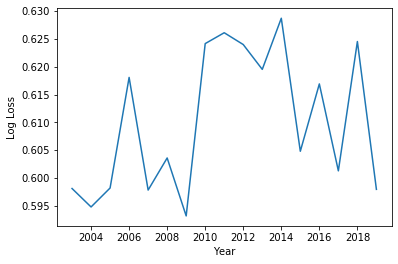

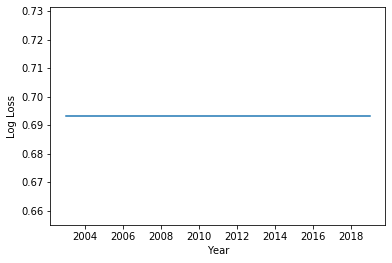

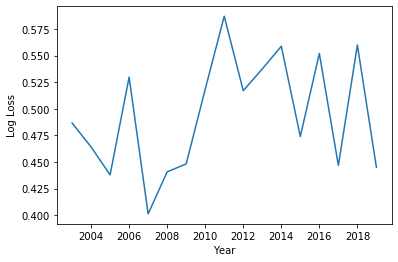

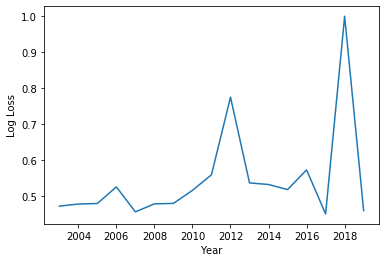

In [245]:
# bulk trial:
estimators = [
    (linear_model.BayesianRidge(), 'reg'),
    (linear_model.ARDRegression(), 'reg'),
    (linear_model.ElasticNetCV(), 'reg'),
    (linear_model.ElasticNet(), 'reg'),
    (linear_model.Lasso(), 'reg'),
    (linear_model.LogisticRegression(), 'cls'),
    (linear_model.SGDRegressor(), 'reg')
]

scores = {}

for e, mode in estimators:
    scores[e.__class__.__name__] = reg_cv_train(
        features=features, 
        estimator=e,
        mode=mode, 
        plot=False, 
        verbose=False)

In [246]:
scores

{'BayesianRidge': 0.5259635063359314,
 'ARDRegression': 0.5265141093393286,
 'ElasticNetCV': 0.5260792305025709,
 'ElasticNet': 0.6101048932893284,
 'Lasso': 0.6931471805599454,
 'LogisticRegression': 0.49442651051396047,
 'SGDRegressor': 0.5455962708033114}